In [11]:
import warnings
import pandas as pd
import numpy as np
from sklearn import metrics
from sklearn.metrics import classification_report, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, cross_val_score, StratifiedKFold
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import RFECV
import matplotlib.pyplot as plt
from graphviz import Source

import time

start_time = time.time()


warnings.filterwarnings('ignore')

df = pd.read_csv('../db/out/wta_s.csv')

In [12]:
df_2023 = df[df['date'].str.contains(
    '2023', na=False) | df['date'].str.contains('2022', na=False)]

df.drop(df_2023.index, inplace=True)

In [13]:
non_numeric_columns = df.select_dtypes(['object']).columns

df_numeric_only = df.drop(non_numeric_columns, axis=1)

df = df_numeric_only

df = df.drop(['match_id'], axis=1)

df = df.fillna(df.median())

df = df.fillna(df.median())

In [14]:
from sklearn.model_selection import train_test_split

Y = pd.DataFrame(df['y'])
df = df.drop(['y'], axis=1)
X = df
X_train, X_test, y_train, y_test = train_test_split(
    X, Y, test_size=0.1, random_state=45, stratify=Y)

non_numeric_columns = df_2023.select_dtypes(['object']).columns

df_numeric_only = df_2023.drop(non_numeric_columns, axis=1)

df_2023 = df_numeric_only

df_2023 = df_2023.drop(['match_id'], axis=1)

df_2023 = df_2023.fillna(df_2023.median())

y_2023 = pd.DataFrame(df_2023['y'])
x_2023 = df_2023.drop(['y'], axis=1)

In [15]:
from sklearn.tree import DecisionTreeClassifier

model = DecisionTreeClassifier(random_state=45)

result = model.fit(X_train, y_train)
y_pred = model.predict(X_test)

basic_report = classification_report(y_test, y_pred, output_dict=True)
print("Trening")
print(basic_report)
basic_pre = basic_report['weighted avg']['precision']


pred_val = model.predict(x_2023)
basic_report = classification_report(y_2023, pred_val, output_dict=True)
print("Walidacja")
print(basic_report)
basic_pre_val = basic_report['weighted avg']['precision']

Trening
{'0': {'precision': 0.5865650969529086, 'recall': 0.5914804469273743, 'f1-score': 0.5890125173852572, 'support': 1432.0}, '1': {'precision': 0.5945945945945946, 'recall': 0.5896907216494846, 'f1-score': 0.5921325051759835, 'support': 1455.0}, 'accuracy': 0.5905784551437478, 'macro avg': {'precision': 0.5905798457737517, 'recall': 0.5905855842884294, 'f1-score': 0.5905725112806204, 'support': 2887.0}, 'weighted avg': {'precision': 0.590611830263838, 'recall': 0.5905784551437478, 'f1-score': 0.5905849393580687, 'support': 2887.0}}
Walidacja
{'0': {'precision': 0.5648535564853556, 'recall': 0.5656424581005587, 'f1-score': 0.5652477320307049, 'support': 1432.0}, '1': {'precision': 0.5622800844475722, 'recall': 0.5614898102600141, 'f1-score': 0.5618846694796061, 'support': 1423.0}, 'accuracy': 0.5635726795096322, 'macro avg': {'precision': 0.5635668204664639, 'recall': 0.5635661341802864, 'f1-score': 0.5635662007551555, 'support': 2855.0}, 'weighted avg': {'precision': 0.56357087672

In [7]:
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier

model = DecisionTreeClassifier(random_state=45)

param_grid = {
    'max_depth': list(range(5, 20, 1)),
    'max_features': ['auto', 'sqrt', 'log2'],
    'criterion': ['gini', 'entropy', 'log_loss'],
    'ccp_alpha': [0.0, 0.2, 0.4, 0.5]
}

search = GridSearchCV(model, param_grid,
                      cv=10, scoring='accuracy', n_jobs=-1, verbose=2)

# search = RFE(model, n_features_to_select=5, step=1)

# execute search
result = search.fit(X_train, y_train)
# summarize result
print('Best Score: %s' % result.best_score_)
print('Best Hyperparameters: %s' % result.best_params_)

Fitting 10 folds for each of 540 candidates, totalling 5400 fits
Best Score: 0.6679370818586292
Best Hyperparameters: {'ccp_alpha': 0.0, 'criterion': 'gini', 'max_depth': 6, 'max_features': 'log2'}


In [16]:
from sklearn.tree import export_graphviz
from graphviz import Source

model = DecisionTreeClassifier(
    max_depth=6, max_features='log2', criterion='gini', ccp_alpha=0.0, random_state=45)


result = model.fit(X_train, y_train)
y_pred = model.predict(X_test)


print(classification_report(y_test, y_pred))
selected_features = model.feature_names_in_

opti_report = classification_report(y_test, y_pred, output_dict=True)
print("Trening")
opti_pre = opti_report['weighted avg']['precision']
opti_f1 = opti_report['weighted avg']['f1-score']
opti_auc = metrics.roc_auc_score(y_test, model.predict_proba(X_test)[::, 1])


pred_val = model.predict(x_2023)
opti_val_report = classification_report(y_2023, pred_val, output_dict=True)
print("Walidacja")
print(opti_val_report)
opti_pre_val = opti_val_report['weighted avg']['precision']
opti_f1_val = opti_val_report['weighted avg']['f1-score']
opti_auc_val = metrics.roc_auc_score(
    y_2023, model.predict_proba(x_2023)[::, 1])

export_graphviz(model, out_file='tree.dot', feature_names=model.feature_names_in_,
                class_names=['0', '1'], rounded=True, filled=True)


# feat_importances = pd.DataFrame(
#     model.feature_importances_, index=X_test.columns, columns=["Importance"])
# feat_importances.sort_values(by='Importance', ascending=False, inplace=True)
# feat_importances.plot(kind='bar', figsize=(8, 6))
# plt.show()

              precision    recall  f1-score   support

           0       0.65      0.68      0.67      1432
           1       0.67      0.65      0.66      1455

    accuracy                           0.66      2887
   macro avg       0.66      0.66      0.66      2887
weighted avg       0.66      0.66      0.66      2887

Trening
Walidacja
{'0': {'precision': 0.6234735413839891, 'recall': 0.6417597765363129, 'f1-score': 0.6324845147969719, 'support': 1432.0}, '1': {'precision': 0.6285300506879073, 'recall': 0.6099789177793394, 'f1-score': 0.6191155492154066, 'support': 1423.0}, 'accuracy': 0.6259194395796848, 'macro avg': {'precision': 0.6260017960359483, 'recall': 0.6258693471578262, 'f1-score': 0.6258000320061892, 'support': 2855.0}, 'weighted avg': {'precision': 0.6259938260563098, 'recall': 0.6259194395796848, 'f1-score': 0.6258211039309237, 'support': 2855.0}}


Optimal number of features : 3
                             Rank
games_played                    1
surface_wins                    1
rank_points                     1
rank                            2
win_percentage                  3
completeness                    4
points_on_return                5
first_won_serve                 6
bp_factor                       7
total_serve_points              8
second_won_serve_vs             9
double_fault_probability       10
second_won_serve               11
aceDf                          12
double_fault_probability_vs    13
ht                             14
glicko                         15
serve_points_won               16
aceDf_vs                       17
ace_probability                18
ace_probability_vs             19
first_won_serve_vs             20
elo                            21
bp_factor_vs                   22
win_percentage_vs              23
Trening
Walidacja
{'0': {'precision': 0.636938202247191, 'recall': 0.6333798882681564

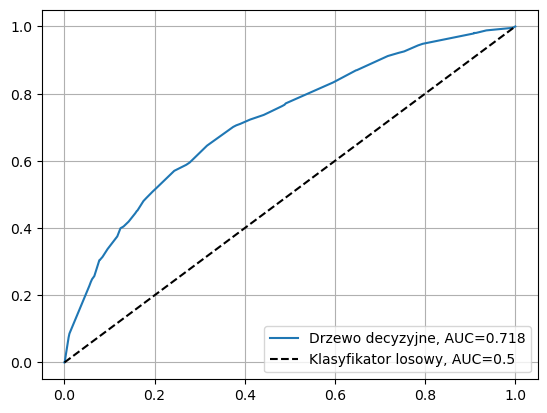

In [23]:
# Decision tree with RFECV
from sklearn.tree import export_graphviz
from graphviz import Source

model = DecisionTreeClassifier(
    max_depth=6, max_features='log2', criterion='gini', random_state=45)


cv = StratifiedKFold(5)

model = RFECV(model, cv=cv, scoring='accuracy', step=1)

model.fit(X_train, y_train)

y_pred = model.predict(X_test)

print('Optimal number of features : %d' % model.n_features_)

ranks = pd.DataFrame(
    model.ranking_, index=X.columns, columns=['Rank'])

print(ranks.sort_values(by='Rank', ascending=True))


selected_features = ranks[ranks['Rank'] == 1].index.values.tolist()

opti_report = classification_report(y_test, y_pred, output_dict=True)
print("Trening")
opti_pre = opti_report['weighted avg']['precision']
opti_f1 = opti_report['weighted avg']['f1-score']
opti_auc = metrics.roc_auc_score(y_test, model.predict_proba(X_test)[::, 1])


pred_val = model.predict(x_2023)
opti_val_report = classification_report(y_2023, pred_val, output_dict=True)
print("Walidacja")
print(opti_val_report)
opti_pre_val = opti_val_report['weighted avg']['precision']
opti_f1_val = opti_val_report['weighted avg']['f1-score']
opti_auc_val = metrics.roc_auc_score(
    y_2023, model.predict_proba(x_2023)[::, 1])


# print(rfecv.feature_names_in_)

ranks = pd.DataFrame(
    model.ranking_, index=X.columns, columns=['Rank'])

ranks_1 = ranks[ranks['Rank'] == 1]

# selected_features = ranks[ranks['Rank'] == 1].index.values.tolist()

export_graphviz(model.estimator_, out_file='tree.dot', feature_names=ranks_1.index.values,
                class_names=['0', '1'], rounded=True, filled=True)


print(selected_features)


print(classification_report(y_test, y_pred))


y_pred_proba = result.predict_proba(X_test)[::, 1]
fpr, tpr, _ = metrics.roc_curve(y_test,  y_pred_proba)
auc = metrics.roc_auc_score(y_test, y_pred_proba)

plt.grid(True)
plt.plot(fpr, tpr, label="Drzewo decyzyjne, AUC="+str(auc)[:5])
plt.plot([0, 1], [0, 1], 'r--',
         label='Klasyfikator losowy, AUC=0.5 ', color='black')
plt.legend(loc=4)
plt.show()

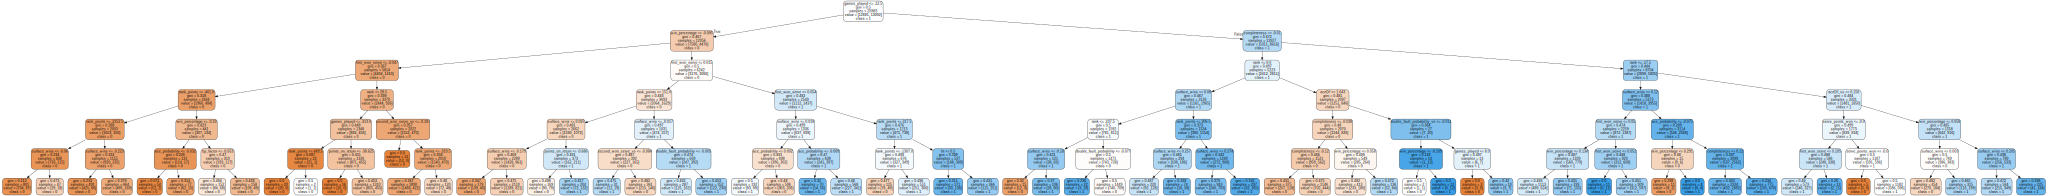

In [17]:
from graphviz import Source
Source.from_file("tree.dot")

In [25]:
import json

filename = 'results.json'

final_results = {
    "prediction_basic": basic_pre,
    "v_prcision_basic": basic_pre_val,
    "prediction_optimized": opti_pre,
    "v_prcision_optimized": opti_pre_val,
    "f1_score_opt": opti_f1,
    "f1_score_opt_val": opti_f1_val,
    "auc_opt": float(opti_auc),
    "auc_opt_val": float(opti_auc_val),
    "selected_features": selected_features,
}

try:
    with open(filename, 'r') as file:
        data = json.load(file)
except FileNotFoundError:
    data = {}

data['Drzewo decyzyjne'] = final_results

with open('results.json', 'w') as file:
    json.dump(data, file, indent=4)